# Ray Tracing in One Weekend

[Ray Tracing in One Weekend](https://raytracing.github.io/books/RayTracingInOneWeekend.html) in a Julia Notebook.

## Vec3

In [1]:
struct Vec3
    x::Float64
    y::Float64
    z::Float64
end

In [2]:
Base.:+(u::Vec3, v::Vec3) = Vec3(u.x + v.x, u.y + v.y, u.z + v.z)

In [3]:
Base.:-(v::Vec3) = Vec3(-v.x, -v.y, -v.z)
Base.:-(u::Vec3, v::Vec3) = Vec3(u.x - v.x, u.y - v.y, u.z - v.z)

In [4]:
Base.:*(u::Vec3, v::Vec3) = Vec3(u.x * v.x, u.y * v.y, u.z * v.z)
Base.:*(v::Vec3, t::Number) = Vec3(v.x * t, v.y * t, v.z * t)
Base.:*(t::Number, v::Vec3) = v * t

In [5]:
Base.:/(v::Vec3, t::Number) = Vec3(v.x / t, v.y / t, v.z / t)

In [6]:
length_squared(v::Vec3) = v.x * v.x + v.y * v.y + v.z * v.z

length_squared (generic function with 1 method)

In [7]:
# length(collection) is for number of elements
length_vector(v::Vec3) = sqrt(length_squared(v))

length_vector (generic function with 1 method)

In [8]:
dot(u::Vec3, v::Vec3) = u.x * v.x + u.y * v.y + u.z * v.z

dot (generic function with 1 method)

In [9]:
cross(u::Vec3, v::Vec3) = Vec3(
    u.y * v.z - u.z * v.y,
    u.z * v.x - u.x * v.z,
    u.x * v.y - u.y * v.x
)

cross (generic function with 1 method)

In [10]:
unit_vector(v::Vec3) = v / length_vector(v)

unit_vector (generic function with 1 method)

In [11]:
reflect(v::Vec3, n::Vec3) = v - 2 * dot(v, n) * n

reflect (generic function with 1 method)

In [12]:
function refract(uv::Vec3, n::Vec3, etai_over_etat::Float64)
    cos_theta = dot(-uv, n)
    r_out_parallel = etai_over_etat * (uv + cos_theta * n)
    r_out_perp = -sqrt(1 - length_squared(r_out_parallel)) * n
    r_out_parallel + r_out_perp
end

refract (generic function with 1 method)

In [13]:
function random_in_unit_sphere()
    while true
        p = Vec3(rand(-1:eps():1, 3)...)
        if length_squared(p) < 1
            return p
        end
    end
 end

random_in_unit_sphere (generic function with 1 method)

In [14]:
function random_unit_vector()
    a = rand(0:eps():2pi)
    z = rand(-1:eps():1)
    r = sqrt(1 - z * z)
    Vec3(r * cos(a), r * sin(a), z)
end

random_unit_vector (generic function with 1 method)

In [15]:
function random_in_hemisphere(normal::Vec3)
    in_unit_sphere = random_in_unit_sphere()
    if dot(in_unit_sphere, normal) > 0
        in_unit_sphere
    else
        -in_unit_sphere
    end
end

random_in_hemisphere (generic function with 1 method)

In [16]:
function random_in_unit_disk()
    while true
        p = Vec3(rand(-1:eps():1), rand(-1:eps():1), 0)
        if length_squared(p) < 1
            return p
        end
    end
end

random_in_unit_disk (generic function with 1 method)

## Ray

In [17]:
struct Ray
    origin::Vec3
    direction::Vec3
end

In [18]:
at(ray::Ray, t::Number) = ray.origin + t * ray.direction

at (generic function with 1 method)

## Hittable and Material

In [19]:
abstract type Hittable end

In [20]:
abstract type Material end

## HitRecord and HittableList

In [21]:
struct HitRecord
    p::Vec3
    normal::Vec3
    mat::Material
    t::Float64
    front_face::Bool
    
    function HitRecord(
            p::Vec3,
            t::Number,
            mat::Material,
            r::Ray,
            outward_normal::Vec3)
        front_face = dot(r.direction, outward_normal) < 0
        normal = front_face ? outward_normal : -outward_normal
        new(p, normal, mat, t, front_face)
    end
end

In [22]:
struct HittableList <: Hittable
    objects::Vector{Hittable}
end

In [23]:
function hit(
        hl::HittableList,
        r::Ray,
        t_min::Number,
        t_max::Number,
        )::Union{HitRecord,Nothing}
    closest_so_far = t_max
    
    hr::Union{HitRecord,Nothing} = nothing
    
    for obj in hl.objects
        temp_hr = hit(obj, r, t_min, closest_so_far)
        if temp_hr != nothing
            closest_so_far = temp_hr.t
            hr = temp_hr
        end
    end
    
    hr
 end

hit (generic function with 1 method)

## Sphere

In [24]:
struct Sphere <: Hittable
    center::Vec3
    radius::Float64
    mat::Material
end

In [25]:
function hit(
        sphere::Sphere,
        r::Ray,
        t_min::Number,
        t_max::Number,
        )::Union{HitRecord,Nothing}
    
    oc = r.origin - sphere.center
    a = length_squared(r.direction)
    half_b = dot(oc, r.direction)
    c = length_squared(oc) - sphere.radius * sphere.radius
    discriminant = half_b * half_b - a * c

    if discriminant > 0
        root = sqrt(discriminant)
        temp = (-half_b - root) / a
        if t_min < temp < t_max
            p = at(r, temp)
            outward_normal = (p - sphere.center) / sphere.radius
            HitRecord(p, temp, sphere.mat, r, outward_normal)
        else
            temp = (-half_b + root) / a
            if t_min < temp < t_max
                p = at(r, temp)
                outward_normal = (p - sphere.center) / sphere.radius
                HitRecord(p, temp, sphere.mat, r, outward_normal)
            end
        end
    end
end

hit (generic function with 2 methods)

## Lambertian

In [26]:
struct Lambertian <: Material
    albedo::Vec3
end

In [27]:
function scatter(
        lambertian::Lambertian,
        r_in::Ray,
        rec::HitRecord,
        )::Tuple{Bool,Vec3,Ray}
    scatter_direction = rec.normal + random_unit_vector()
    scattered = Ray(rec.p, scatter_direction)
    attenuation = lambertian.albedo
    true, attenuation, scattered
end

scatter (generic function with 1 method)

## Metal

In [28]:
struct Metal <: Material
    albedo::Vec3
    fuzz::Float64
    
    Metal(albedo::Vec3, fuzz::Number) = new(albedo, fuzz < 1 ? fuzz : 1)
 end

In [29]:
function scatter(
        metal::Metal, 
        r_in::Ray,
        rec::HitRecord)::Tuple{Bool,Vec3,Ray}
    reflected = reflect(unit_vector(r_in.direction), rec.normal)
    scattered = Ray(rec.p, reflected)
    attenuation = metal.albedo
    dot(scattered.direction, rec.normal) > 0, attenuation, scattered
end

scatter (generic function with 2 methods)

## Dielectric

In [30]:
function schlick(cosine::Float64, ref_idx::Float64)
    r0 = (1 - ref_idx) / (1 + ref_idx)
    r0 *= r0
    r0 + (1 - r0) * (1 - cosine)^5
 end

schlick (generic function with 1 method)

In [31]:
struct Dielectric <: Material
    ref_idx::Float64
end

In [32]:
function scatter(
        dielectric::Dielectric,
        r_in::Ray,
        rec::HitRecord
        )::Tuple{Bool,Vec3,Ray}
    attenuation = Vec3(1, 1, 1)
    etai_over_etat = 
    rec.front_face ? 1 / dielectric.ref_idx : dielectric.ref_idx
    
    unit_direction = unit_vector(r_in.direction)
    cos_theta = min(dot(-unit_direction, rec.normal), 1)
    sin_theta = sqrt(1 - cos_theta * cos_theta)
    
    if etai_over_etat * sin_theta > 1
        reflected = reflect(unit_direction, rec.normal)
        scattered = Ray(rec.p, reflected)
        true, attenuation, scattered
    else
        reflect_prob = schlick(cos_theta, etai_over_etat)
        if rand() < reflect_prob
            reflected = reflect(unit_direction, rec.normal)
            scattered = Ray(rec.p, reflected)
            true, attenuation, scattered
        else
            refracted = refract(unit_direction, rec.normal, etai_over_etat)
            scattered = Ray(rec.p, refracted)
            true, attenuation, scattered
        end
    end
end

scatter (generic function with 3 methods)

## Camera

In [33]:
struct Camera
    origin::Vec3
    lower_left_corner::Vec3
    horizontal::Vec3
    vertical::Vec3
    u::Vec3
    v::Vec3
    w::Vec3
    lens_radius::Float64
    
    function Camera(
            lookfrom::Vec3,
            lookat::Vec3,
            vup::Vec3,
            vfov::Number,
            aspect_ratio::Number,
            aperture::Float64,
            focus_dist::Float64)
        origin = lookfrom
        lens_radius = aperture / 2
        
        theta = deg2rad(vfov)
        half_height = tan(theta / 2)
        half_width = aspect_ratio * half_height

        w = unit_vector(lookfrom - lookat)
        u = unit_vector(cross(vup, w))
        v = cross(w, u)

        lower_left_corner = origin - half_width * focus_dist * u - half_height * focus_dist * v - focus_dist * w

        horizontal = 2 * half_width * focus_dist * u
        vertical = 2 * half_height * focus_dist * v

        new(origin, lower_left_corner, horizontal, vertical, u, v, w, lens_radius)
    end
end

In [34]:
function get_ray(camera::Camera, s::Number, t::Number)::Ray
    rd = camera.lens_radius * random_in_unit_disk()
    offset = camera.u * rd.x + camera.v * rd.y

     Ray(
        camera.origin + offset,
        camera.lower_left_corner + s * camera.horizontal + t * camera.vertical - camera.origin - offset)
 end

get_ray (generic function with 1 method)

## Image

In [35]:
using Images

In [36]:
const aspect_ratio = 16 / 9
const image_width = 384
const image_height = Int(image_width ÷ aspect_ratio)
const samples_per_pixel = 100
const max_depth = 50;

In [37]:
const lookfrom = Vec3(3, 3, 2)
const lookat = Vec3(0, 0, -1)
const vup = Vec3(0, 1, 0)
const dist_to_focus = length_vector(lookfrom - lookat)
const aperture = 2.0

2.0

In [38]:
const cam = Camera(lookfrom, lookat, vup, 20.0, aspect_ratio, aperture, dist_to_focus)

Camera(Vec3(3.0, 3.0, 2.0), Vec3(-0.7777170036948506, -0.7480920225906305, 0.5258090262854811), Vec3(2.3035260299803317, 0.0, -2.3035260299803317), Vec3(-0.7480920225906307, 1.4961840451812614, -0.7480920225906307), Vec3(0.7071067811865475, 0.0, -0.7071067811865475), Vec3(-0.40824829046386296, 0.8164965809277259, -0.40824829046386296), Vec3(0.5773502691896257, 0.5773502691896257, 0.5773502691896257), 1.0)

In [39]:
const world = HittableList([
        Sphere(Vec3(0, 0, -1), 0.5, Lambertian(Vec3(0.1, 0.2, 0.5))),
        Sphere(Vec3(0, -100.5, -1), 100, Lambertian(Vec3(0.8, 0.8, 0))),
        Sphere(Vec3(1, 0, -1), 0.5, Metal(Vec3(0.8, 0.6, 0.2), 0.3)),
        Sphere(Vec3(-1, 0, -1), 0.5, Dielectric(1.5)),
        Sphere(Vec3(-1, 0, -1), -0.45, Dielectric(1.5)),
        ])

HittableList(Hittable[Sphere(Vec3(0.0, 0.0, -1.0), 0.5, Lambertian(Vec3(0.1, 0.2, 0.5))), Sphere(Vec3(0.0, -100.5, -1.0), 100.0, Lambertian(Vec3(0.8, 0.8, 0.0))), Sphere(Vec3(1.0, 0.0, -1.0), 0.5, Metal(Vec3(0.8, 0.6, 0.2), 0.3)), Sphere(Vec3(-1.0, 0.0, -1.0), 0.5, Dielectric(1.5)), Sphere(Vec3(-1.0, 0.0, -1.0), -0.45, Dielectric(1.5))])

In [40]:
function ray_color(r::Ray, depth::Int)
    if depth <= 0
        return Vec3(0, 0, 0)
    end
    
    hr = hit(world, r, 0.001, Inf)
    
    if hr != nothing
        did_scatter, attenuation, scattered = scatter(hr.mat, r, hr)
        if did_scatter
            attenuation * ray_color(scattered, depth - 1)
        else
            Vec3(0, 0, 0)
        end
    else
        unit_direction = unit_vector(r.direction)
        t = 0.5 * (unit_direction.y + 1)
        (1 - t) * Vec3(1, 1, 1) + t * Vec3(0.5, 0.7, 1)
    end
end

ray_color (generic function with 1 method)

In [41]:
function color(i::Int, j::Int)
    c = Vec3(0, 0, 0)
    for _ = 1:samples_per_pixel
        u = (i + rand()) / image_width
        v = (j + rand()) / image_height
        r = get_ray(cam, u, v)
        c += ray_color(r, max_depth)
    end
    c /= samples_per_pixel
    RGB(sqrt(c.x), sqrt(c.y), sqrt(c.z))
end

color (generic function with 1 method)

In [42]:
function render()
    [color(i, j) for j in image_height:-1:1, i in 1:image_width]
end

render (generic function with 1 method)

  3.969855 seconds (22.44 M allocations: 1.674 GiB, 4.21% gc time)


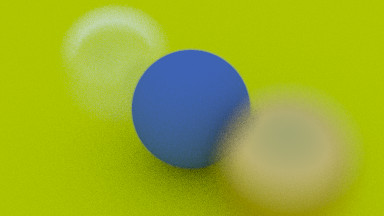

In [43]:
@time render()